In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
from collections import defaultdict

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
import json

In [6]:
import sys
sys.path.append('/home/robin/github/forked/ProtoPool/')

In [7]:
from model import PrototypeChooser

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def get_vectors(data_path):
    
    model_path = '/home/robin/github/forked/ProtoPool/results_analysis/checkpoint/birds_descriptive-10_prototypes-202_lr-0.0005_resnet50_True_log_log_warmup_ll_mixup_iNaturalist_seed-4307_2023-05-06_232259/best_model.pth'
    
    batch_size = 80
    
    # Load the test dataset
    transforms_train_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder(data_path, transform=transforms_train_test)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Load the best model
    model = PrototypeChooser(
            num_prototypes=202,
            num_descriptive=10,
            num_classes=100, #200,
            use_thresh=True,
            arch='resnet50',
            pretrained=True,
            add_on_layers_type='log',
            prototype_activation_function='log',
            proto_depth=256,
            use_last_layer=True,
            inat=True)

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])
    model = model.cuda()
    model.eval()

    # Evaluate the model on the test dataset
    tst_acc, total = 0, 0
    x_activation_s, x_activation_avg_s, x_activation_subs, label_s = [], [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.cuda()
            labels = labels.cuda()

            prob, _, _, (x_activation, x_activation_avg) = model(images, gumbel_scale=10e3)

            # vectors for analysis:
            x_activation_s.append(x_activation)
            x_activation_avg_s.append(x_activation_avg)
            x_activation_subs.append(x_activation - x_activation_avg)
            label_s.append(labels)

            # sanity check - accuracy:
            _, predicted = torch.max(prob, 1)
            true = labels
            tst_acc += (predicted == true).sum()
            total += labels.size(0)

    tst_acc = tst_acc.item() / total
    print(f'Test Accuracy: {tst_acc * 100:.2f}%')
    
    
    # Concatenate all the tensors in the lists
    x_activation_s = torch.cat(x_activation_s).cpu().numpy().tolist()
    x_activation_avg_s = torch.cat(x_activation_avg_s).cpu().numpy().tolist()
    x_activation_subs = torch.cat(x_activation_subs).cpu().numpy().tolist()
    labels = torch.cat(label_s).cpu().numpy()
    
    labels_2_classes = {l:c for l,c in zip(np.unique(labels), dataset.classes)}
    classes = [labels_2_classes[l] for l in labels]
    labels = [int(c[:3]) for c in classes]
    
    
    vectors = {
        'labels':labels,
        'classes':classes,
        'x_activation_s':x_activation_s,
        'x_activation_avg_s':x_activation_avg_s,
        'x_activation_subs':x_activation_subs
    }

    return vectors

In [10]:
data_paths = [
    '/home/robin/d/CUB_200_2011/train_cropped_in',
    '/home/robin/d/CUB_200_2011/train_cropped_out',
    '/home/robin/d/CUB_200_2011/test_cropped_in',
    '/home/robin/d/CUB_200_2011/test_cropped_out'
    ]

In [11]:
data_vectors = {}
for data_path in data_paths:
    data_name = data_path.split('/')[-1]
    print(data_name)
    data_vectors[data_name] = get_vectors(data_path)

train_cropped_in
Test Accuracy: 100.00%
train_cropped_out
Test Accuracy: 11.45%
test_cropped_in
Test Accuracy: 89.76%
test_cropped_out
Test Accuracy: 10.95%


In [12]:
def visualize_tsne(vectors):

    # Create T-SNE model
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-2)

    # Perform T-SNE on the activations
    x_activation_2d = tsne.fit_transform(vectors['x_activation_s'])
    x_activation_avg_2d = tsne.fit_transform(vectors['x_activation_avg_s'])
    x_activation_subs_2d = tsne.fit_transform(vectors['x_activation_subs'])

    # Function to plot the 2D embeddings
    def plot_embeddings(embeddings_2d, labels, title):
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.5)
        plt.title(title)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="upper left")
        plt.show()
        


    # Plot the embeddings
    plot_embeddings(x_activation_2d, vectors['labels'], 'T-SNE of x_activation_s')
    plot_embeddings(x_activation_avg_2d, vectors['labels'], 'T-SNE of x_activation_avg_s')
    plot_embeddings(x_activation_subs_2d, vectors['labels'], 'T-SNE of x_activation_subs')


train_cropped_in


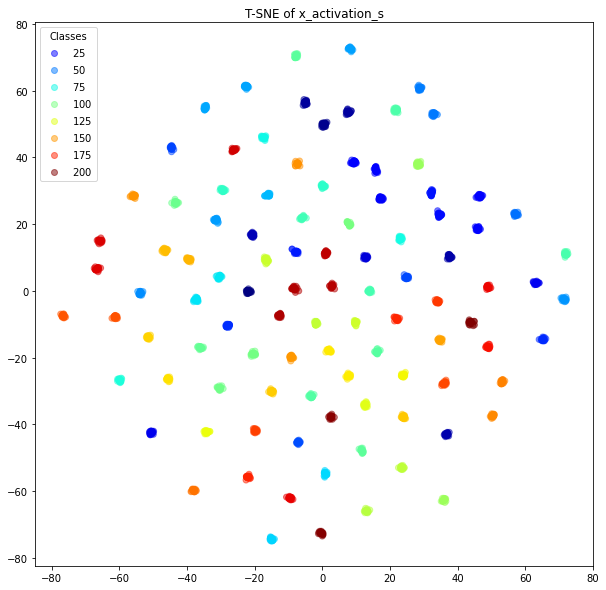

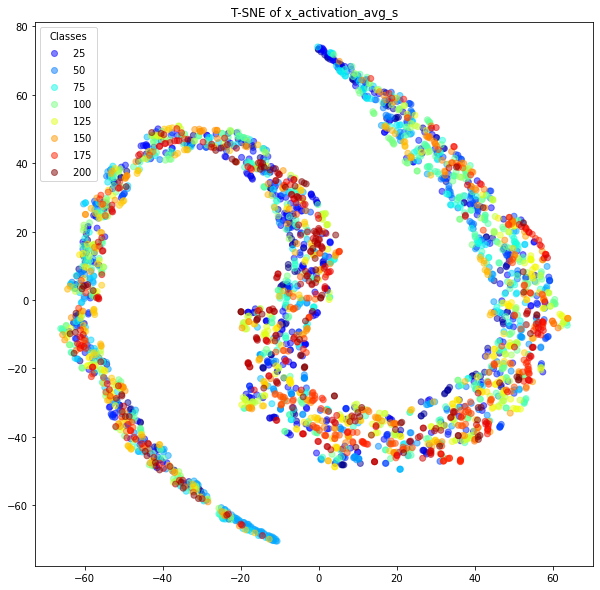

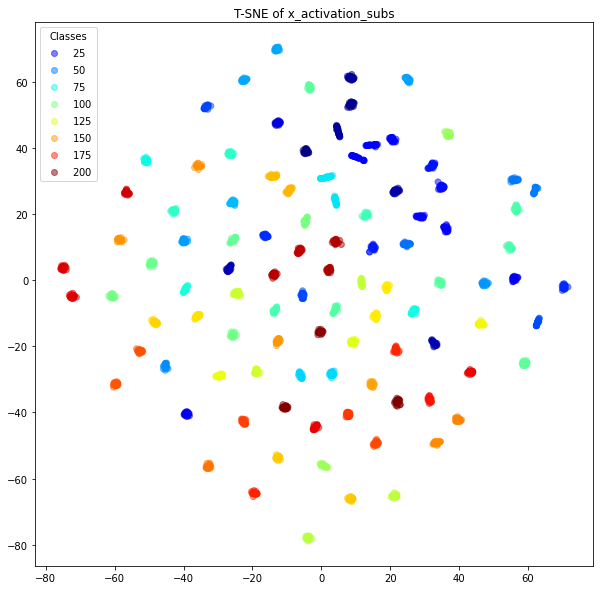

train_cropped_out


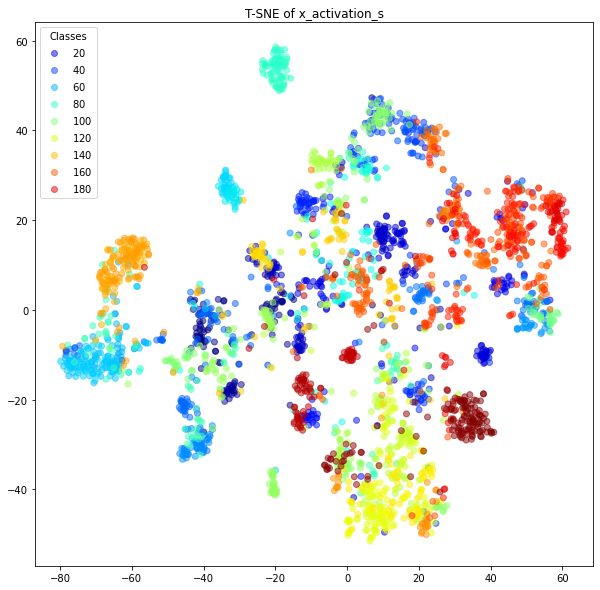

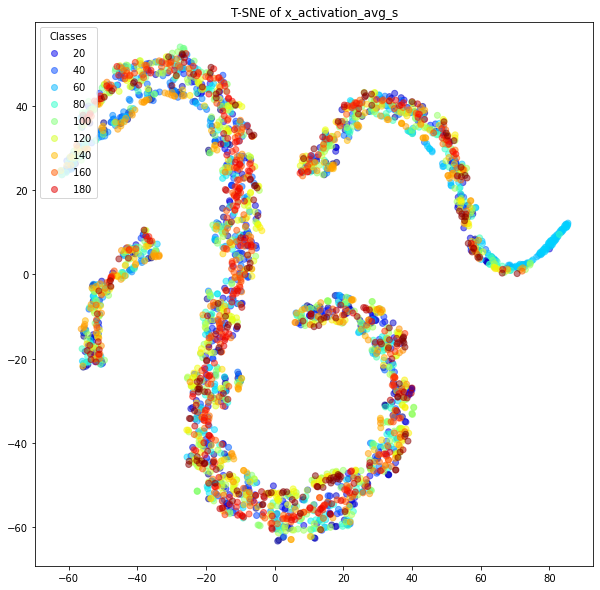

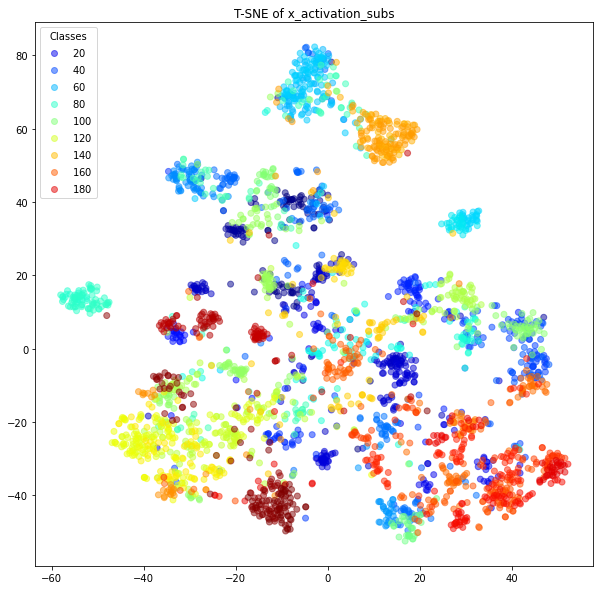

test_cropped_in


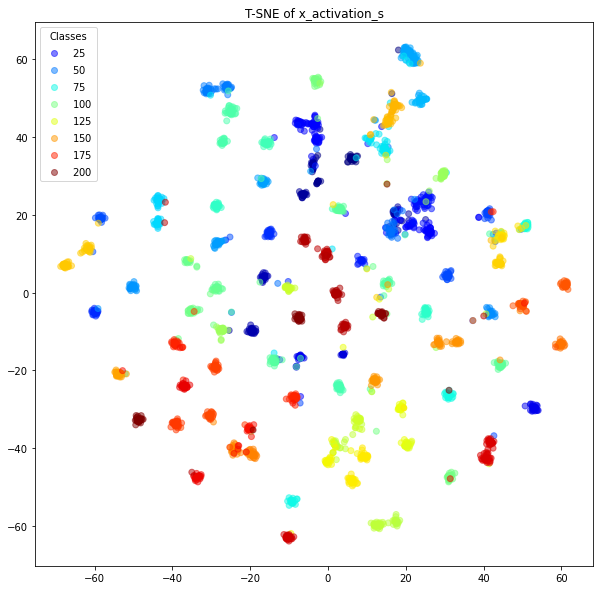

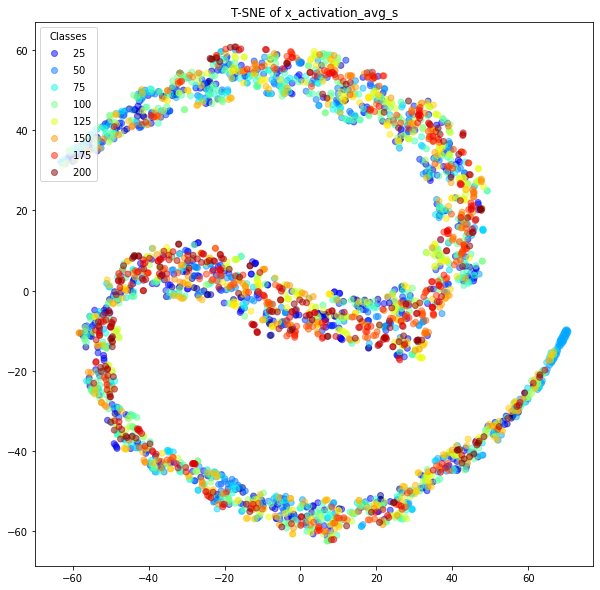

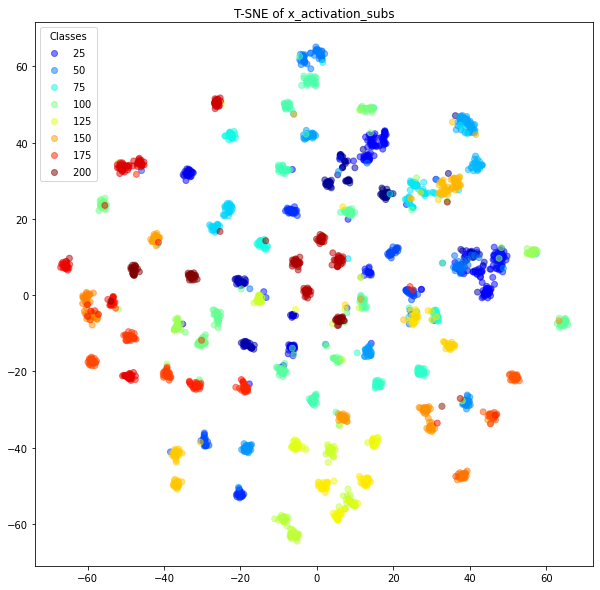

test_cropped_out


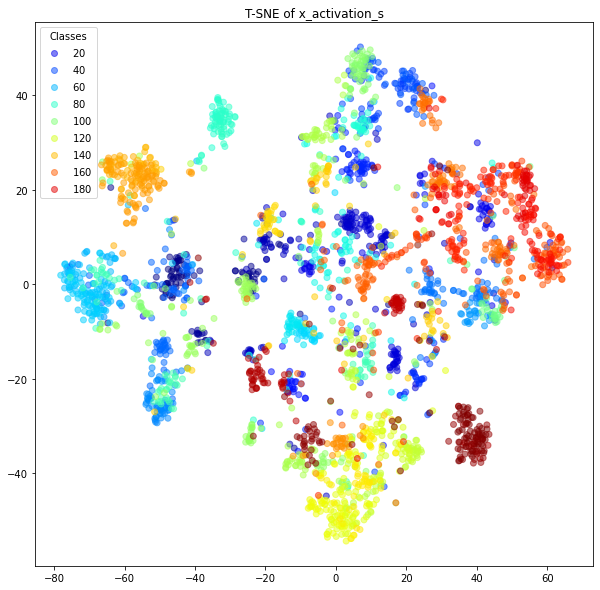

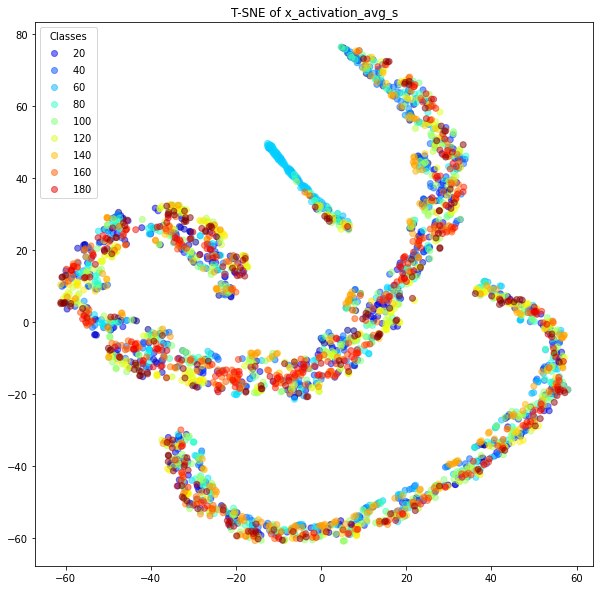

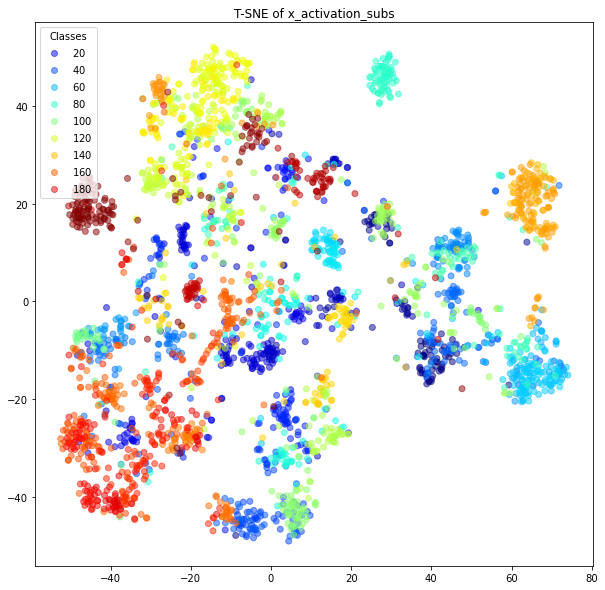

In [13]:
for data_path in data_paths:
    data_name = data_path.split('/')[-1]
    print(data_name)
    visualize_tsne(data_vectors[data_name])

In [14]:
# Save the dictionary to a JSON file
with open('data_vectors.json', 'w') as json_file:
    json.dump(data_vectors, json_file, ensure_ascii=False, indent=4)